#Face Mask Detection Model

In [1]:
%pip install kagglehub

In [71]:
# นำเข้า modules ของ libraries
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from PIL import Image
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, r2_score, mean_squared_error, log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from kagglehub import login, dataset_download
from pandas import DataFrame

In [3]:
# Login เข้า Kaggle (ต้องดาวโหลด์ใบ credentail จาก kaggle ก่อนแล้วเอา username กับ key มากรอก)
# หรือถ้าไม่มีให้ใช้ข้อมูลด้านล่างต่อไปนี้

# ให้นำค่า value ไปกรอกในฟอร์มของ kaggle
kaggle_api = {
    "username":"warinsaipanya",
    "key":"e9d6ec16f057b50fac90908de9990b27"
}

login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [4]:
# ดาวโหลด์ตัว datasets จาก kaggle เก็บไว้ใน path ที่ระบุ
path = dataset_download("andrewmvd/face-mask-detection")
print(f"path ของไฟล์ dataset อยู่ที่: {path}")

path ของไฟล์ dataset อยู่ที่: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1


In [5]:
# classes เป็น list ไว้เก็บคำตอบ
classes = ["mask worn incorrectly", "with mask", "without mask"]

In [6]:
# ชื่อ models ทั้งหมด
model_names = ("Neural Network", "KNN", "Desicion Tree", "Random Forest")

# สร้างตัวแปรเก็บเป็น list ไว้เก็บค่าตัวเลขผลลัพธ์ของ model เพื่อนำไป plot graph และ ทำตาราง
accuracy_values = []
precision_values = []
recall_values = []

# function สำหรับเพิ่มค่า element ให้ตัวแปร list ด้านบน
def add_elements(accuracy, precision, recall):
  accuracy_values.append(accuracy)
  precision_values.append(precision)
  recall_values.append(recall)

In [7]:
# path ที่เก็บข้อมูลรูปภาพไว้ train
folder_path = f"{path}/images"
# path ที่เก็บข้อมูลไฟล์ xml
xml_folder = f"{path}/annotations"

In [8]:
# สร้าง list ไว้เก็บข้อมูล x และ y
# x สำหรับเก็บข้อมูล features ของรูปภาพ
x = []
# y สำหรับเก็บคำตอบของรูปภาพ
y = []

In [9]:
# function สำหรับการอ่านข้อมูลในไฟล์ xml
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    # เก็บข้อมูลใน tag ของ object
    objects = []

    # วน loop หา element ที่มีชื่อว่า object และได้กลับคืนมาเป็น list แล้ววน loop
    for obj in root.findall("object"):
        # หา tag ที่ชื่อ name แล้วอ่าน content ด้านในเก็บ class คำตอบของรูป
        label = obj.find("name").text
        # หา tag bndbox
        bndbox = obj.find("bndbox")
        # อ่านข้อมูลด้านใน element bndbox แล้วแปลงค่าเป็น int
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        # เพื่อ dictionary เข้าไปใน list
        objects.append({"label": label, "bbox": [xmin, ymin, xmax, ymax]})

    return objects

In [10]:
def extract_number(filename):
    match = re.search(r"\d+", filename)
    return int(match.group()) if match else -1

In [11]:
# list เก็บชื่อไฟล์ xml แบบเรียงลำดับชื่อไฟล์เป็นไฟล์ข้อมูลสำหรับแต่หล่ะรูปภาพ
xml_files = sorted(os.listdir(xml_folder), key=extract_number)
# สร้าง object ของ label encoder ไว้ normalize ตัว label ของรูป
encoder = LabelEncoder()

# แสดงผล list ที่เก็บไฟล์ xml ไว้
print(xml_files)

['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss2.xml', 'maksssksksss3.xml', 'maksssksksss4.xml', 'maksssksksss5.xml', 'maksssksksss6.xml', 'maksssksksss7.xml', 'maksssksksss8.xml', 'maksssksksss9.xml', 'maksssksksss10.xml', 'maksssksksss11.xml', 'maksssksksss12.xml', 'maksssksksss13.xml', 'maksssksksss14.xml', 'maksssksksss15.xml', 'maksssksksss16.xml', 'maksssksksss17.xml', 'maksssksksss18.xml', 'maksssksksss19.xml', 'maksssksksss20.xml', 'maksssksksss21.xml', 'maksssksksss22.xml', 'maksssksksss23.xml', 'maksssksksss24.xml', 'maksssksksss25.xml', 'maksssksksss26.xml', 'maksssksksss27.xml', 'maksssksksss28.xml', 'maksssksksss29.xml', 'maksssksksss30.xml', 'maksssksksss31.xml', 'maksssksksss32.xml', 'maksssksksss33.xml', 'maksssksksss34.xml', 'maksssksksss35.xml', 'maksssksksss36.xml', 'maksssksksss37.xml', 'maksssksksss38.xml', 'maksssksksss39.xml', 'maksssksksss40.xml', 'maksssksksss41.xml', 'maksssksksss42.xml', 'maksssksksss43.xml', 'maksssksksss44.xml', 'maksssksksss45.xml

In [12]:
# วน loop แต่ล่ะชื่อ xml file
for file in xml_files:
    # เอา path ของที่เก็บไฟล์ xml  มา join กับชื่อไฟล์ จะได้ตำแหน่ง path ที่แท้จริงของไฟล์ xml
    file_path = os.path.join(xml_folder, file)

    # เช็คตรวจสอบไฟล์ว่ามี path ไฟล์นั้นอยู่จริงไหม หรือไฟล์นั้นไม่ใช่ไฟล์ นามสกุล .xml ให้ข้าม loop นั้น
    if not os.path.isfile(file_path) or not file.lower().endswith('.xml'):
        continue

    try:
        # แปลงไฟล์ นามสกุลลงท้าย .xml เป็น .png ชื่อไฟล์ xml กับ ชื่อรูปภาพเหมือนกันต่างกันแค่คนหล่ะนามสกุลไฟล์
        image_name = file.replace(".xml", ".png")
        # เอา path ที่เก็บรูปภาพมา join กับ ชื่อไฟล์รูปภาพที่พึ่งแก้นามสกุลไฟลืไป ได้เป็น path ของรูปภาพที่แท้จริง
        image_path = os.path.join(folder_path, image_name)

        # เช็คเงื่อนไขถ้า path ของรูปภาพไม่มีอยู่ ให้ข้าม loop นั้นไป
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        # เปิดรูปภาพตามตำแหน่งของ path รูปภาพแล้วแปลงรูปภาพนั้นให้เป็น grayscale
        img = Image.open(image_path).convert('L')
        # ปรับขนาดของรูปภาพที่ size หลายขนาดให้เป็นขนาด 512 x 512 (height = width)
        img = img.resize((512, 512))
        # เพิ่ม element เข้าไปใน list โดยให้รูปภาพปรับขนาดรูปร่างความกว้างและความสูงเป็น 512 และ มีช่องสีแค่ 1
        x.append(np.array(img).reshape(512, 512, 1))

        # เรียกใช้ function ได้เป็น list ที่เก็บ dictionary ที่เป็นคุณสมบัติของรูปภาพ
        objects = parse_xml(file_path)

        # เช็คถ้า objects นั้นไม่ใช้ list ว่าง (มี elements อยู่ใน list) ให้ทำเงื่อนไขด้านล่างนี้
        if objects:
            # อ่านคำตอบมาแค่ 1 คนจากรูปภาพนั้น
            # ให้ตัวแปร y เก็บ class ของคำตอบแต่ล่ะรูป
            y.append(objects[0]["label"])
        else:
            print(f"Warning: No objects found in {file_path}")
            continue
    except Exception as e:
        print(f"Error processing {file}: {e}")

# เช็คถ้าข้อมูลนั้นไม่มีอยู่ให้โยน exception นี้ออกไป
if len(x) == 0 or len(y) == 0:
    raise ValueError("No data found! Check your dataset paths and XML annotations.")

# encoded ตัวคำตอบ labels แปลงจาก string -> int ค่าอยู่ในช่วง 0 - 2
y = encoder.fit_transform(y)
# แปลงข้อมูล array จากชนิด unsigned int -> float และหารด้วย 255 เพิ่อแปลงเป็น grayscale
x = np.array(x).astype('float32') / 255
# แบ่งข้อมูล train และ test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
# แสดงผลขนาดรูปร่างของข้อมูล train และ test
# จำนวนข้อมูลรูปภาพมีทั้งหมด 853 รูป แบ่งเป็น train 682 รูป และ test 171 รูป
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(682, 512, 512, 1)
(171, 512, 512, 1)
(682,)
(171,)


### Neural Netwoerk Model

In [14]:
# สร้าง object ของ model
model = Sequential()

# เพิ่มแต่ล่ะ layers ให้ model
model.add(Flatten(input_shape=(512, 512, 1)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
# train model 14 รอบ
model.fit(x_train, y_train, epochs=14)

Epoch 1/14
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.6057 - loss: 169.1197
Epoch 2/14
22/22 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.6638 - loss: 37.8411
Epoch 3/14
22/22 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.6745 - loss: 6.7555
Epoch 4/14
22/22 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.7483 - loss: 1.2121
Epoch 5/14
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.7861 - loss: 1.1950
Epoch 6/14
22/22 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.8010 - loss: 1.0322
Epoch 7/14
22/22 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.7304 - loss: 1.0117
Epoch 8/14
22/22 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.7959 - loss: 0.9974
Epoch 9/14
22/22 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.8098 - loss: 0.9731
Epoch 10/14
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.8017 - loss: 0.9542
Epoch 11/14
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8032 - loss: 0.9348
Epoch 12/14
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.807

In [17]:
# คำนวณค่า accuracy และ ค่า loss ของ model
loss, accuracy = model.evaluate(x_test, y_test)

# แสดงผลค่าออกมา
print(f"Accuracy: {accuracy}")
print(f"Loss: {loss}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.8609 - loss: 0.8512
Accuracy: 0.8830409646034241
Loss: 0.8407837152481079


In [18]:
# ทำนายค่าผลลัพธ์
y_pred = np.argmax(model.predict(x_test), axis=-1)

# คำนวณค่า precision และ recall
# Add average='weighted' for multiclass classification
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")

# แสดงผลลัพธ์
print(f"Precision: {precision}")
print(f"Recall: {recall}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 880ms/step
Precision: 0.7797612940733901
Recall: 0.8830409356725146


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
# เรียกใช้ function เพิ่มค่าที่สำคัญเข้าไปใน list
add_elements(accuracy, precision, recall)

In [20]:
# แปลงจาก array 4 มิติให้เป็น array 2 มิติ
x_train2 = x_train.reshape(x_train.shape[0], -1)
x_test2 = x_test.reshape(x_test.shape[0], -1)
# แปลงเป็๋น array 1 มิติ
y_train2 = y_train.ravel()
y_test2 = y_test.ravel()

In [21]:
# แสดงรูปร้่างของข้อมูล train และ test
print(x_train2.shape)
print(x_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

(682, 262144)
(171, 262144)
(682,)
(171,)


### KNN Model

In [22]:
# กำหนดโมเดล KNN
knn = KNeighborsClassifier(n_neighbors=15)

# ฝึกโมเดล KNN
knn.fit(x_train2, y_train2)

# ทำนายผลลัพธ์ในชุดทดสอบ
y_pred_knn = knn.predict(x_test2)

# คำนวณความแม่นยำของโมเดล KNN
accuracy_knn = accuracy_score(y_test2, y_pred_knn)

# คำนวณ  loss สำหรับ KNN โดยใช้ค่าความน่าจะเป็นจากการทำนาย
y_pred_prob = knn.predict_proba(x_test2)

# กำหนดคลาสที่ต้องการใช้ในการคำนวณ  loss
KNN_loss = log_loss(y_test2, y_pred_prob, labels=[0, 1, 2])

# คำนวณ precision และ recall ของ KNN
precision_knn = precision_score(y_test2, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test2, y_pred_knn, average='weighted')

# เพิ่มค่าผลลัพธ์ของ KNN เข้าไปใน list สำหรับเปรียบเทียบ
add_elements(accuracy_knn, precision_knn, recall_knn)

# แสดงผลความแม่นยำของ KNN ,  precision , recall และ loss
print(f"KNN Accuracy: {accuracy_knn:.4f}")
print(f"KNN Precision: {precision_knn:.4f}")
print(f"KNN Recall: {recall_knn:.4f}")
print(f"KNN Loss: {KNN_loss:.4f}")

KNN Accuracy: 0.8713
KNN Precision: 0.7785
KNN Recall: 0.8713
KNN Loss: 0.8197


### Desicion Tree Model

In [23]:
# สร้าง Random Forest Model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# ฝึก Random Forest Model
random_forest_model.fit(x_train2, y_train2)

# ทำนายค่าผลลัพธ์จากข้อมูลทดสอบ
rf_y_pred = random_forest_model.predict(x_test2)

# ทำนายค่าความน่าจะเป็นจาก Random Forest Model
rf_y_prob = random_forest_model.predict_proba(x_test2)

# คำนวณ Log Loss
rf_loss = log_loss(y_test2, rf_y_prob, labels=[0, 1, 2])

# คำนวณ Precision, Recall สำหรับ Random Forest
rf_precision = precision_score(y_test2, rf_y_pred, average='weighted')
rf_recall = recall_score(y_test2, rf_y_pred, average='weighted')

# คำนวณ Accuracy
rf_accuracy = random_forest_model.score(x_test2, y_test2)

# แสดงผลลัพธ์ของ Random Forest Model
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest Precision: {rf_precision}")
print(f"Random Forest Recall: {rf_recall}")
print(f"Random Forest Loss: {rf_loss}")

# เพิ่มผลลัพธ์ของ Random Forest ลงใน list
add_elements(rf_accuracy, rf_precision, rf_recall)

Random Forest Accuracy: 0.8771929824561403
Random Forest Precision: 0.8221595655806181
Random Forest Recall: 0.8771929824561403
Random Forest Loss: 0.7036669222565244


### Random Forest Model

In [24]:
# สร้าง model random forest
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
# train model
rfc_model.fit(x_train2, y_train2)

# คำนวณค่า precision และ ค่า recall
rfc_precision_score = precision_score(y_test2, rfc_model.predict(x_test2))
rfc_recall_score = recall_score(y_test2, rfc_model.predict(x_test2))

# คำนวณค่า accuracy
rfc_test_acc = accuracy_score(y_test2, rfc_model.predict(x_test2))

# loss
rfc_loss = log_loss(y_train2,rfc_model.predict_proba(x_train2))

# แสดงผลลัพธ์
print("RFC Test Accuracy:", rfc_test_acc)
print("RFC Loss:", rfc_loss)
print("RFC Precision Score:", rfc_precision_score)
print("RFC Recall Score:", rfc_recall_score)

# เพิ่มค่าผลลัพธ์เข้าไปใน list
add_elements(rfc_test_acc, rfc_precision_score, rfc_recall_score)

RFC Test Accuracy: 0.8771929824561403
RFC Loss: 0.14825277902340767
RFC Precision Score: 0.8869047619047619
RFC Recall Score: 0.9867549668874173


### ตาราง

In [25]:
# สร้าง object ของ dataframe เพื่อทำตาราง
df = DataFrame()

### Plot graphs

In [26]:
# ปริ้นค่าผลลัพธ์ที่เก็บมา
print(accuracy_values)
print(precision_values)
print(recall_values)

[0.8830409646034241, 0.8713450292397661, 0.8771929824561403, 0.8771929824561403]
[0.7797612940733901, 0.7785390497941106, 0.8221595655806181, 0.8869047619047619]
[0.8830409356725146, 0.8713450292397661, 0.8771929824561403, 0.9867549668874173]


In [93]:
# กำหนดค่าสีแต่ละ model ในกราฟแท่ง
bar_colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green']
# ไว้กำหนดค่าที่แสดงในแกน y
y_labels = []

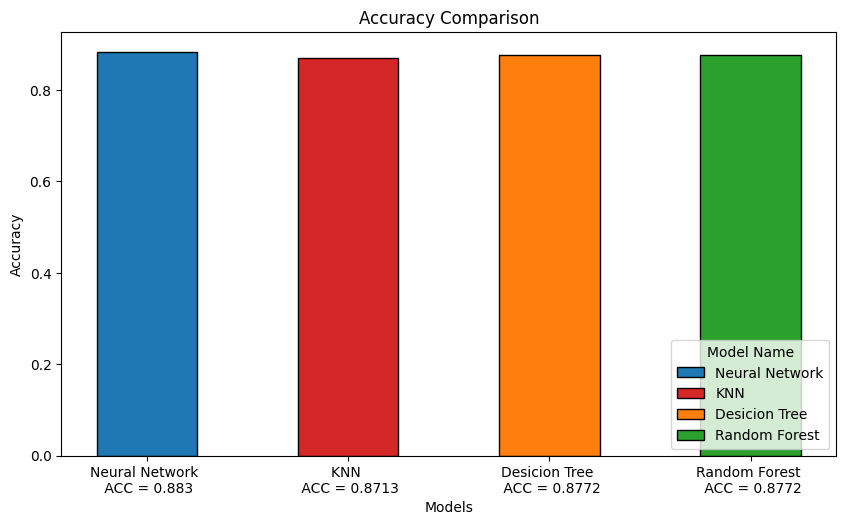

In [94]:
# วน loop เพิ่มค่า y labels
for i, name in enumerate(model_names):
  y_labels.append(f'{name} \n ACC = {round(accuracy_values[i], 4)}')

# ปรับขนาดของกราฟ
figure(figsize=(10, 5.5))

# แสดงกราฟค่า accuracy
plt.bar(y_labels, accuracy_values, width=.5, label=model_names, color=bar_colors, edgecolor='0')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend(title='Model Name', loc='lower right')
plt.show()

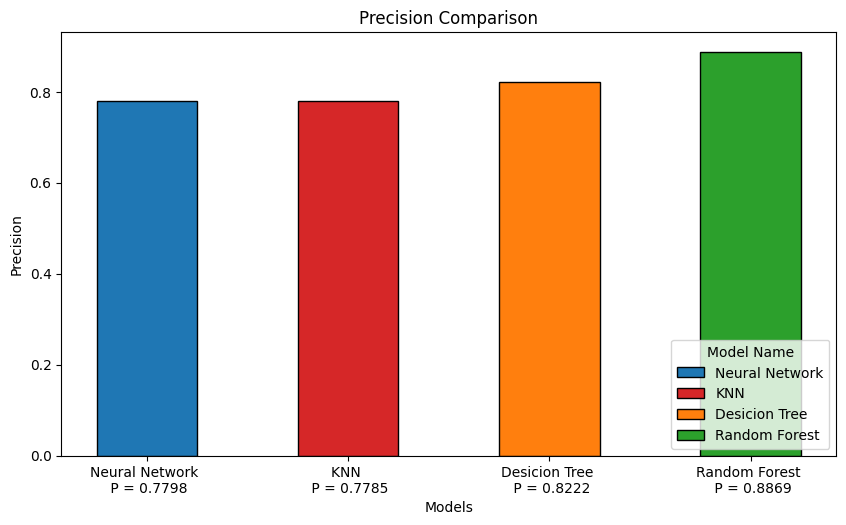

In [95]:
# clear ค่า elements ออกทั้งหมด
y_labels.clear()

# วน loop เพิ่มค่า y labels
for i, name in enumerate(model_names):
  y_labels.append(f'{name} \n P = {round(precision_values[i], 4)}')


# ปรับขนาดของกราฟ
figure(figsize=(10, 5.5))

# แสดงกราฟค่า precision
plt.bar(y_labels, precision_values, width=.5, label=model_names, color=bar_colors, edgecolor='0')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.legend(title='Model Name', loc='lower right')
plt.show()

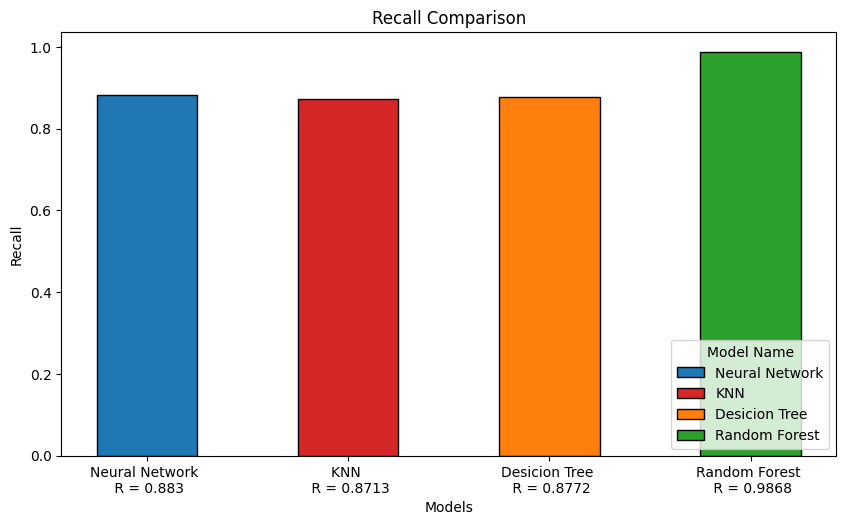

In [96]:
# clear ค่า elements ออกทั้งหมด
y_labels.clear()

# วน loop เพิ่มค่า y labels
for i, name in enumerate(model_names):
  y_labels.append(f'{name} \n R = {round(recall_values[i], 4)}')

# ปรับขนาดของกราฟ
figure(figsize=(10, 5.5))

# แสดงกราฟค่า recall
plt.bar(y_labels, recall_values, width=.5, label=model_names, color=bar_colors, edgecolor='0')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.legend(title='Model Name', loc='lower right')
plt.show()